In [63]:
import numpy as np

In [64]:
colors = {
    "Baseline": (26/255, 29/255, 26/255, 1),
    "Kong_no-auth": (63/255, 222/255, 148/255, 1),
    "Kong": (25/255, 145/255, 89/255, 1),
    "Istio": (65/255, 85/255, 153/255, 1)
}

In [65]:
# load response times
import json

with open("compiled_response_times.json", 'r') as file:
    response_times = json.load(file)

In [66]:
# load numpy calculated statiscics
import json

with open("statistics.json", 'r') as file:
    statistics = json.load(file)

In [67]:
# compare jmeter & numpy median
import pandas as pd

methods = ["Baseline", "Kong_no-auth", "Kong", "Istio"]

d = {"Method": [], "Tool": [], "1": [], "5": [], "10": [], "50": [], "100": []}

for method in methods:
    # numpy
    d["Method"].append(method)
    d["Tool"].append("NumPy")
    for threads in statistics[method]:
        d[threads].append(statistics[method][threads]["50"])

    # Jmeter
    d["Method"].append(method)
    d["Tool"].append("Jmeter")
    for threads in response_times[method]:
        if method == "Baseline":
            method = "vanilla"
        with open(f"{method}/graph/u{threads}/statistics.json", 'r') as file:
            jmeter_stats = json.load(file)
        d[threads].append(jmeter_stats["Total"]["medianResTime"])


df = pd.DataFrame(data=d)
print("Median")
df



Median


,Method,Tool,1,5,10,50,100
0,Baseline,NumPy,2.0,4.0,5.0,72.0,101.0
1,Baseline,Jmeter,2.0,4.0,5.0,66.0,99.0
2,Kong_no-auth,NumPy,2.0,4.0,5.0,84.0,107.0
3,Kong_no-auth,Jmeter,2.0,4.0,5.0,81.0,157.0
4,Kong,NumPy,2.0,4.0,5.0,89.0,114.0
5,Kong,Jmeter,2.0,4.0,6.0,88.0,111.0
6,Istio,NumPy,4.0,6.0,9.0,85.0,165.0
7,Istio,Jmeter,4.0,7.0,9.0,90.0,183.0


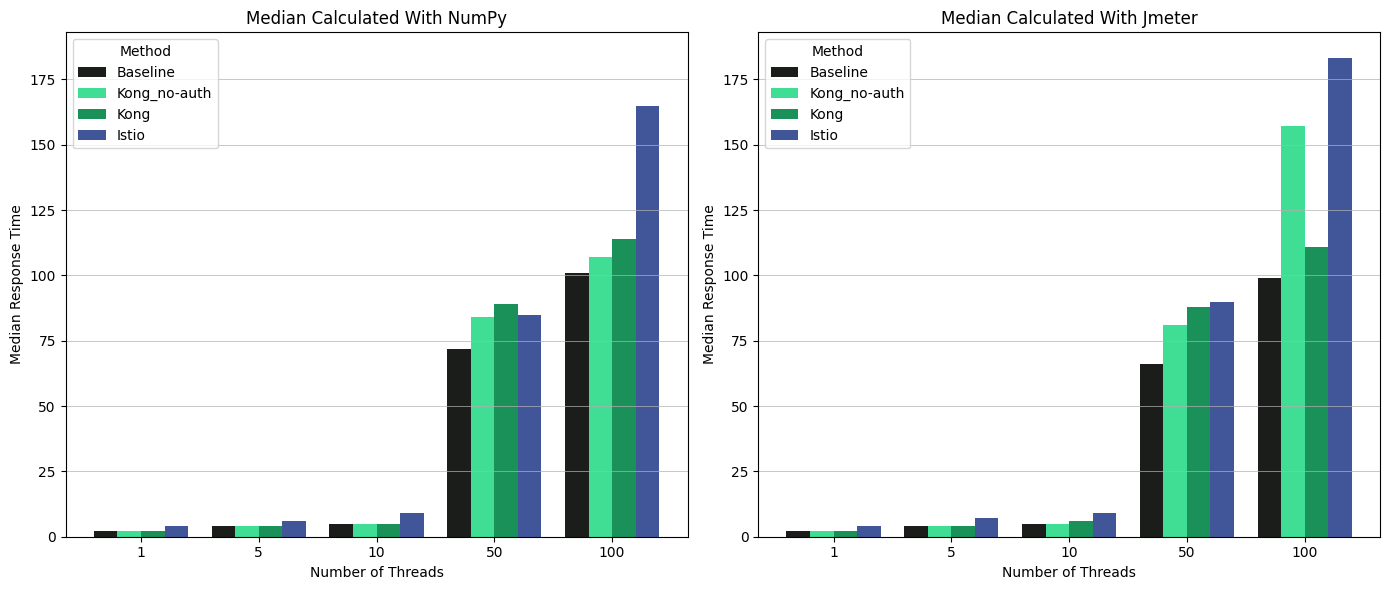

In [68]:
import matplotlib.pyplot as plt


# separate data frame for numpy and Jmeter
df_numpy = df[df["Tool"] == "NumPy"].set_index("Method")
df_jmeter = df[df["Tool"] == "Jmeter"].set_index("Method")

# ensure data frame is numeric for max calculations
df_numpy_numeric = df_numpy.drop(columns=["Tool"]).apply(pd.to_numeric, errors='coerce')
df_jmeter_numeric = df_jmeter.drop(columns=["Tool"]).apply(pd.to_numeric, errors='coerce')

# fixate y axis for both plots with highest value + add some room to improve readability
ymax = max(df_numpy_numeric.max().max(), df_jmeter_numeric.max().max()) + 10

# define width and position of each bar
bar_width = 0.2  # Width of each bar
n_methods = len(df_numpy_numeric.index.unique())
indices = np.arange(len(df_numpy_numeric.columns))

plt.figure(figsize=(14, 6))

# numpy
plt.subplot(1, 2, 1)
for i, method in enumerate(df_numpy_numeric.index.unique()):
    offset = (i - n_methods / 2) * bar_width + bar_width / 2
    plt.bar(indices + offset, df_numpy_numeric.loc[method], width=bar_width, label=method, color=colors[method])

plt.title('Median Calculated With NumPy')
plt.ylabel('Median Response Time')
plt.xlabel('Number of Threads')
plt.xticks(indices, df_numpy_numeric.columns)
plt.ylim(0, ymax)
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.legend(title='Method')

# Jmeter
plt.subplot(1, 2, 2)
for i, method in enumerate(df_jmeter_numeric.index.unique()):
    offset = (i - n_methods / 2) * bar_width + bar_width / 2
    plt.bar(indices + offset, df_jmeter_numeric.loc[method], width=bar_width, label=method, color=colors[method])

plt.title('Median Calculated With Jmeter')
plt.ylabel('Median Response Time')
plt.xlabel('Number of Threads')
plt.xticks(indices, df_jmeter_numeric.columns)
plt.ylim(0, ymax)
plt.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5)
plt.legend(title='Method')

plt.tight_layout()
plt.savefig("custom_plots/Median_comparison.png")
plt.show()


In [69]:
# get number of smaples below and above median, including it
import pandas as pd

methods = ["Baseline", "Kong_no-auth", "Kong", "Istio"]

d_diff = {"Method": [], "Tool": [], "Diff1": [], "Diff5": [], "Diff10": [], "Diff50": [], "Diff100": []}

for method in methods:
    # numpy
    d_diff["Method"].append(method)
    d_diff["Tool"].append("NumPy")
    for threads in statistics[method]:
        numpy_med = statistics[method][threads]["50"]
        low = [val for val in response_times[method][threads] if val <= numpy_med]
        high = [val for val in response_times[method][threads] if val >= numpy_med]

        difference = np.absolute(len(low)-len(high))
        d_diff[f"Diff{threads}"].append(difference)

    # Jmeter
    d_diff["Method"].append(method)
    d_diff["Tool"].append("Jmeter")
    for threads in response_times[method]:
        if method == "Baseline":
            method = "vanilla"
        with open(f"{method}/graph/u{threads}/statistics.json", 'r') as file:
            jmeter_stats = json.load(file)

        jmeter_med = jmeter_stats["Total"]["medianResTime"]

        if method == "vanilla":
            method = "Baseline"
        low = [val for val in response_times[method][threads] if val <= jmeter_med]
        high = [val for val in response_times[method][threads] if val >= jmeter_med]

        difference = np.absolute(len(low)-len(high))
        d_diff[f"Diff{threads}"].append(difference)

df = pd.DataFrame(data=d_diff)
print("Size difference between array below and above median")
df

Size difference between array below and above median


,Method,Tool,Diff1,Diff5,Diff10,Diff50,Diff100
0,Baseline,NumPy,14126,74942,6493,165,1832
1,Baseline,Jmeter,14126,74942,6493,20859,13280
2,Kong_no-auth,NumPy,21740,21527,45087,1125,363
3,Kong_no-auth,Jmeter,21740,21527,45087,10526,28576
4,Kong,NumPy,22998,73987,51835,1022,870
5,Kong,Jmeter,22998,73987,103359,6318,10330
6,Istio,NumPy,949,66342,22468,2439,565
7,Istio,Jmeter,949,201107,22468,55139,48253


In [70]:
# how many values are between the two calculated medians?
diff = {"Method": [], "Values1": [], "Values5": [], "Values10": [], "Values50": [], "Values100": []}

thread_number = ["1", "5", "10", "50", "100"]


for i in range(len(d["Method"])):
    if d["Method"][i] == d["Method"][i-1]:
        diff["Method"].append(d["Method"][i])
        for thread in thread_number:
            
            minimum = min([d[thread][i], d[thread][i-1]])
            maximum = max([d[thread][i], d[thread][i-1]])

            diff[f"Values{thread}"].append(len([val for val in response_times[d["Method"][i]][thread] if val > minimum and val < maximum]))

print("Number of values between the calculated medians from NumPy and Jmeter")

df = pd.DataFrame(data=diff)
df

Number of values between the calculated medians from numpy and Jmeter


,Method,Values1,Values5,Values10,Values50,Values100
0,Baseline,0,0,0,8696,3891
1,Kong_no-auth,0,0,0,3077,13690
2,Kong,0,0,0,0,3093
3,Istio,0,0,0,21209,23197


In [71]:
# compare jmeter & numpy Average
import pandas as pd

methods = ["Baseline", "Kong_no-auth", "Kong", "Istio"]

d = {"Method": [], "Tool": [], "1": [], "5": [], "10": [], "50": [], "100": []}

for method in methods:
    # numpy
    d["Method"].append(method)
    d["Tool"].append("NumPy")
    for threads in statistics[method]:
        d[threads].append(statistics[method][threads]["avg"])

    # Jmeter
    d["Method"].append(method)
    d["Tool"].append("Jmeter")
    for threads in response_times[method]:
        if method == "Baseline":
            method = "vanilla"
            
        with open(f"{method}/graph/u{threads}/statistics.json", 'r') as file:
            jmeter_stats = json.load(file)
        d[threads].append(jmeter_stats["Total"]["meanResTime"])

df = pd.DataFrame(data=d)
print("Average")
df

Average


,Method,Tool,1,5,10,50,100
0,Baseline,NumPy,2.108530,4.029789,13.056044,87.047895,179.114982
1,Baseline,Jmeter,2.108530,4.029789,13.056044,87.047895,179.114982
2,Kong_no-auth,NumPy,2.150714,4.148318,13.471148,90.064105,183.552708
3,Kong_no-auth,Jmeter,2.150714,4.148318,13.471148,90.064105,183.552708
4,Kong,NumPy,2.155312,4.063281,14.028303,119.469055,242.023793
5,Kong,Jmeter,2.155312,4.063281,14.028303,119.469055,242.023793
6,Istio,NumPy,4.133001,6.961627,14.281778,91.123228,182.067869
7,Istio,Jmeter,4.133001,6.961627,14.281778,91.123228,182.067869
